# NOTES
TODO: <br>
- figure out how to distinguish animals
- finish FINAL event based on empty spaces detection (if none => show text "game won" in the top left corner of frame)
- try to match woolf on dices using Canny? 1. check how boarding box of dice looks like, how the woolf looks like to see if it makes sense. if it does, take rotation into concideration . Try matchTemplate or ORB? maybe something else 
- detect TRADE box. has to be 1. outside of board (not yet detectable) 2. maybe check for black rectangle? [dont use any corner-like, as it wont work on dificult. Can only get in correspondence to board. maybe as a {big} square outside of board] in the trade box search if theres a circle (as defined in function that detects circles [circle size has to be defined in correspondence to the board]. If there is a circle=> trigger "TRADING" event and write it on top left corner of the frame)
- try to merge tracking dice with final detection. Change the code so that its all in functions, triggered in each frame and readable.
#### do not think that matching sheep to sheep or figuring out anything on dice is possible. stick to shapes and colours. 



### What has to be done: 
Events: <br>
1. Trading
2. Wolf 
3. Rolling dice / getting animal   --done
4. Dog buying
5. Final

<br>
Possible events:

- Fox (hard to detect)

Tracking: <br>
1. Dice   --done
2. Board??? computationally expensive, maybe will make sense for difficult. Not necessary. Do not try unless all else is finished



#### project description:

- perp of dataset
- persentation of results
- detection of Dice and animals, board (position can be calculated from board position)
- tracking movement of dice

<Br> 
For 4: 

- detection of 2 events ( corresponding message on the screeen)
<br><br>

For 5: 

- game status (# of animals)
- detection of 5 events
- track gameplay score (no score for us- singleplayer)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import sys
import glob
import random

from pprint import pprint
from ipywidgets import Video

from PIL import Image
from PIL.ExifTags import TAGS

# opening video, basic characteristics

In [ ]:
game = cv2.VideoCapture("./materials/short.mp4")
if game.isOpened():
    print("video loaded")
    
game_width = int(game.get(3))
game_height = int(game.get(4))

print(game_width, game_height)

game_fps = game.get(cv2.CAP_PROP_FPS)
print(game_fps)

# opening image

In [ ]:
temp_o_1 = cv2.imread("./materials/cow2.png", cv2.IMREAD_GRAYSCALE)
temp_o_1_width, temp_o_1_height = temp_o_1.shape[:2]


# Dice detection

In [ ]:
import cv2
import numpy as np

video_path = "./materials/uppig.mov"
game = cv2.VideoCapture(video_path)
if game.isOpened():
    print("Video loaded")

target_width, target_height = 1024, 768

original_width = int(game.get(cv2.CAP_PROP_FRAME_WIDTH))
original_height = int(game.get(cv2.CAP_PROP_FRAME_HEIGHT))
game_fps = game.get(cv2.CAP_PROP_FPS)

# Scaling factors for resizing
scale_x = target_width / original_width
scale_y = target_height / original_height

#My colors
orange_lower = np.array([4, 66, 114])  # Lower bound for orange                 #change this if colors for dice dont work.
orange_upper = np.array([15, 252, 253])  # Upper bound for orange
blue_lower = np.array([90, 80, 100])    # Lower bound for light blue
blue_upper = np.array([120, 255, 255])   # Upper bound for light blue


output_path = "./output/track_1.avi"
output_video = cv2.VideoWriter(
    output_path,
    cv2.VideoWriter_fourcc(*"DIVX"),
    game_fps,
    (target_width, target_height),
)

trackers = []

def create_tracker(tracker_type="CSRT"):
    if tracker_type == "CSRT":
        return cv2.TrackerCSRT_create()
    elif tracker_type == "KCF":
        return cv2.TrackerKCF_create()
    return None

def draw_bbox_with_area(frame, bbox, color=(255, 255, 255)):
    """Draws a bounding box and displays its area."""
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)
    text_position = (p1[0], max(0, p1[1] - 10))
    cv2.putText(
        frame,
        f"Dice",
        text_position,
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        color,
        1,
        cv2.LINE_AA,
    )

def is_square(bbox, tolerance=0.2):
    x, y, w, h = bbox
    aspect_ratio = w / h if w > h else h / w
    return 1 - tolerance <= aspect_ratio <= 1 + tolerance

def is_overlap(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper, threshold=0.3):
    x, y, w, h = bbox
    roi = frame[y:y+h, x:x+w]  # Extract ROI
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)  # Convert ROI to HSV
    orange_mask = cv2.inRange(hsv_roi, orange_lower, orange_upper)
    blue_mask = cv2.inRange(hsv_roi, blue_lower, blue_upper)
    orange_pixels = cv2.countNonZero(orange_mask)
    blue_pixels = cv2.countNonZero(blue_mask)
    total_pixels = w * h
    return (orange_pixels + blue_pixels) / total_pixels >= threshold

# Start tracking
while game.isOpened():
    ret, frame = game.read()
    if not ret:
        break

    # Resize the frame
    frame = cv2.resize(frame, (target_width, target_height))
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Create masks for orange and blue dice
    orange_mask = cv2.inRange(hsv_frame, orange_lower, orange_upper)
    blue_mask = cv2.inRange(hsv_frame, blue_lower, blue_upper)
    combined_mask = cv2.bitwise_or(orange_mask, blue_mask)

    # Find contours
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    detected_bboxes = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if 1000 < area < 4500:  # Area thresholds
            x, y, w, h = cv2.boundingRect(contour)
            if is_square((x, y, w, h)):
                detected_bboxes.append((x, y, w, h, area))

    # Check for new dice to track
    for bbox_data in detected_bboxes:
        bbox = bbox_data[:4]
        area = bbox_data[4]
        is_new = True
        for tracker, tracked_bbox in trackers:
            if is_overlap(bbox, tracked_bbox):
                is_new = False
                break

        if is_new and is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
            tracker = create_tracker("KCF")
            tracker.init(frame, bbox)
            trackers.append((tracker, bbox))
            print(f"New dice detected and tracking initialized at {bbox}")

    # Update trackers
    for i, (tracker, _) in enumerate(trackers):
        ok, bbox = tracker.update(frame)
        if ok:
            if is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                trackers[i] = (tracker, bbox)
                area = bbox[2] * bbox[3]
                draw_bbox_with_area(frame, bbox, (0, 255, 0))
            else:
                print(f"Tracker {i} lost valid target at {bbox}")
                trackers[i] = None
        else:
            print(f"Tracker {i} failed at {bbox}")
            trackers[i] = None

    # Remove invalid trackers
    trackers = [t for t in trackers if t is not None]

    # Save frame to output video
    output_video.write(frame)
    cv2.imshow("Dice Tracking", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

game.release()
output_video.release()
cv2.destroyAllWindows()


Video loaded
New dice detected and tracking initialized at (934, 675, 90, 75)
Tracker 0 failed at (0, 0, 0, 0)
New dice detected and tracking initialized at (974, 655, 50, 54)
Tracker 0 failed at (0, 0, 0, 0)
New dice detected and tracking initialized at (846, 601, 60, 56)
New dice detected and tracking initialized at (759, 580, 68, 62)
Tracker 0 failed at (0, 0, 0, 0)
Tracker 0 failed at (0, 0, 0, 0)
New dice detected and tracking initialized at (730, 555, 67, 61)
New dice detected and tracking initialized at (828, 553, 54, 61)
Tracker 0 failed at (0, 0, 0, 0)
Tracker 1 failed at (0, 0, 0, 0)
New dice detected and tracking initialized at (829, 530, 62, 66)
New dice detected and tracking initialized at (699, 514, 64, 59)
Tracker 1 failed at (0, 0, 0, 0)
New dice detected and tracking initialized at (667, 471, 66, 59)
Tracker 0 failed at (0, 0, 0, 0)
New dice detected and tracking initialized at (838, 494, 74, 67)
Tracker 0 failed at (0, 0, 0, 0)
New dice detected and tracking initializ

# detecting empty animal spaces (USE FOR FINALE DETECTION)

In [11]:
import cv2
import numpy as np
from collections import Counter

def get_dominant_color(image, mask):
    # Extract colors within the mask
    colors = image[mask == 255]
    if len(colors) == 0:
        return (0, 0, 0)  # Default if no pixels found in mask

    # Convert to a list of tuples and count frequencies
    colors = [tuple(color) for color in colors]
    most_common_color = Counter(colors).most_common(1)[0][0]

    return most_common_color

def detect_circles_and_colors(video_path):
    # Open video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)

        # Detect circles using HoughCircles
        circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, param1=200, param2=100, minRadius=10, maxRadius=100)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for circle in circles[0, :]:
                x, y, r = circle

                # Create a circular mask for the detected circle
                mask = np.zeros_like(gray, dtype=np.uint8)
                cv2.circle(mask, (x, y), r, 255, -1)

                # Get dominant color inside the circle
                dominant_color = get_dominant_color(frame, mask)
                color_name = f"RGB({dominant_color[2]}, {dominant_color[1]}, {dominant_color[0]})"

                # Draw the circle and bounding box
                cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
                cv2.rectangle(frame, (x - r, y - r - 20), (x + r, y - r), (0, 255, 0), -1)

                # Put text (dominant color)
                cv2.putText(frame, color_name, (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

        # Show the frame
        cv2.imshow("Circles and Colors", frame)

        # Exit on pressing 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Replace 'video.mp4' with the path to your video file
detect_circles_and_colors('./materials/upright.mp4')


# Detecting all circles (animals) 

In [ ]:
import cv2 
import numpy as np

def detect_board_and_calibrate(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) == 4:
            board = approx
            return board

    return None

def get_dominant_color(frame, mask):
    # Convert the frame to the LAB color space
    lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)

    # Apply the mask to the LAB image
    mask_flat = mask.flatten()
    lab_flat = lab.reshape((-1, 3))
    color_mask = lab_flat[mask_flat == 255]

    # Calculate the mean of the masked region
    mean_color = np.mean(color_mask, axis=0)
    return mean_color

# from scipy.stats import mode

# def get_dominant_color(frame, mask):
#     # Convert the frame to the LAB color space
#     lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)

#     # Apply the mask to the LAB image
#     mask_flat = mask.flatten()
#     lab_flat = lab.reshape((-1, 3))
#     color_mask = lab_flat[mask_flat == 255]

#     # Find the mode (most frequent color) in each channel
#     dominant_color = mode(color_mask, axis=0, keepdims=False).mode
#     return dominant_color



def compute_circle_size_from_board(board):
    # Compute board dimensions (assumes rectangle in perspective)
    distances = [
        np.linalg.norm(board[i][0] - board[(i+1) % 4][0]) for i in range(4)
    ]
    avg_distance = sum(distances) / len(distances)

    # Define circle size based on average board dimension
    return avg_distance / 12  

def detect_circles_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read the first frame to calibrate
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return
    
    # Detect the board
    board = detect_board_and_calibrate(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    # Compute circle size based on the board dimentions
    circle_size = compute_circle_size_from_board(board)
    tolerance = 0.07 * circle_size  

    while True:
        # Read next frame
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)

        # Detect circles using HoughCircles
        circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=70, param2=30, minRadius=int(circle_size - tolerance), maxRadius=int(circle_size + tolerance))


        if circles is not None:
            circles = np.uint16(np.around(circles))
            
            detected_circles = []
            for circle in circles[0, :]:
                x, y, r = circle

                # Create a circular mask for the detected circle
                mask = np.zeros_like(gray, dtype=np.uint8)
                cv2.circle(mask, (x, y), r, 255, -1)

                # Get dominant color inside the circle
                dominant_color = get_dominant_color(frame, mask)
                print(dominant_color)
                color_name = f"({dominant_color[2]}, {dominant_color[1]}, {dominant_color[0]})"

                print(dominant_color)
                # Draw the circle and bounding box
                cv2.circle(frame, (x, y), r, (dominant_color[2], dominant_color[1], dominant_color[0]), 4)
                # cv2.rectangle(frame, (x - r, y - r - 20), (x + r, y - r), (0, 255, 0), -1)

                # Put text (dominant color)
                # cv2.putText(frame, color_name, (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                
#THIS CODE CHECKS FOR OVERLAPPING, BUT DOESNT GET THE COLOR OF THE CIRCLE 
        # if circles is not None:
        #     circles = np.uint16(np.around(circles))
        #     detected_circles = []

        #     for circle in circles[0, :]:
        #         x, y, r = circle

        #         # Check for overlapping circles
        #         overlap = False
        #         for detected in detected_circles:
        #             dx, dy, dr = detected
        #             if np.sqrt((x - dx) ** 2 + (y - dy) ** 2) < 50:
        #                 overlap = True
        #                 break

        #         if not overlap:
        #             detected_circles.append((x, y, r))

        #             # Draw the circle and bounding box
        #             cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
        #             cv2.rectangle(frame, (x - r, y - r - 20), (x + r, y - r), (0, 255, 0), -1)

        #             # Put text (circle size)
        #             size_text = f"Size: {r}"
        #             cv2.putText(frame, size_text, (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

        cv2.imshow("Circles in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


detect_circles_in_video('./materials/upright.mp4')


[188.15673636 135.8247131  143.19933973]
[188.15673636 135.8247131  143.19933973]
[205.1601119  122.11601119 123.82211618]
[205.1601119  122.11601119 123.82211618]
[187.61214415 134.58828369 144.0287971 ]
[187.61214415 134.58828369 144.0287971 ]
[189.95803851 135.27678131 143.73358565]
[189.95803851 135.27678131 143.73358565]
[187.87757117 134.74477538 144.47951292]
[187.87757117 134.74477538 144.47951292]
[137.60135819 111.85897992 150.9810721 ]
[137.60135819 111.85897992 150.9810721 ]
[141.91864151 110.9314717  148.65086792]
[141.91864151 110.9314717  148.65086792]
[198.49070265 134.49366464 142.00822774]
[198.49070265 134.49366464 142.00822774]
[193.14195881 122.96840119 126.3188178 ]
[193.14195881 122.96840119 126.3188178 ]
[135.57177358 144.94943396 153.01449057]
[135.57177358 144.94943396 153.01449057]
[145.12463607 122.98738389 132.90711216]
[145.12463607 122.98738389 132.90711216]
[188.08491032 134.566727   144.07536613]
[188.08491032 134.566727   144.07536613]
[135.01831059 11

# Detecting board in each frame, circles main color (for all circles) ( a lot of false positives )

In [1]:
### THIS DETECTS BOARD IN EACH FRAME, DETECT CIRCLES AND THEIR COLORS
import cv2 
import numpy as np
from scipy.stats import mode

def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 3)
    edges = cv2.Canny(gray, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.imshow("sd", edges)

    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) == 4:
            # Calculate the bounding box
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)

            # Check aspect ratio and solidity
            if 0.95 <= aspect_ratio <= 1.05:  # Allowing some tolerance for a square
                if cv2.isContourConvex(approx):  # Check contour solidity
                    board = approx
                    return board

    return None



def get_dominant_color(frame, mask):
    # Flatten the mask and the frame for easier indexing
    mask_flat = mask.flatten()
    frame_flat = frame.reshape((-1, 3))

    # Select the pixels in the masked region
    color_mask = frame_flat[mask_flat == 255]

    # Check if any pixels are selected
    if color_mask.size == 0:
        return (0, 0, 0)  # Default to black if the mask region is empty

    # Find the mode (most frequent color) in each channel
    dominant_color = mode(color_mask, axis=0, keepdims=False).mode

    # Ensure the result is a tuple
    return tuple(map(int, dominant_color))


def compute_circle_size_from_board(board):
    # Compute board dimensions (assumes rectangle in perspective)
    distances = [
        np.linalg.norm(board[i][0] - board[(i+1) % 4][0]) for i in range(4)
    ]
    avg_distance = sum(distances) / len(distances)

    # Define circle size based on average board dimension
    return avg_distance / 12  

def detect_circles_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read the first frame to calibrate
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return
    
    # Detect the board
    board = detect_board(frame)
    print(board)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    # Compute circle size based on the board dimentions
    circle_size = compute_circle_size_from_board(board)
    tolerance = 0.07 * circle_size  

    while True:
        # Read next frame
        ret, frame = cap.read()
        if not ret:
            break
        board = detect_board(frame)
        if board is not None:
            cv2.polylines(frame, [board], isClosed=True, color=(255, 0, 255), thickness=4)
        

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)

        # Detect circles using HoughCircles
        circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=70, param2=30, minRadius=int(circle_size - tolerance), maxRadius=int(circle_size + tolerance))

        if circles is not None:
            circles = np.uint16(np.around(circles))
            
            detected_circles = []
            for circle in circles[0, :]:
                x, y, r = circle

                # Create a circular mask for the detected circle
                mask = np.zeros_like(gray, dtype=np.uint8)
                cv2.circle(mask, (x, y), r, 255, -1)

                # Get dominant color inside the circle
                dominant_color = get_dominant_color(frame, mask)
                # color_name = f"({dominant_color[2]}, {dominant_color[1]}, {dominant_color[0]})"
                color_name = f"({dominant_color})"
                
                # Draw the circle and bounding box
                cv2.circle(frame, (x, y), r, (int(dominant_color[0]), int(dominant_color[1]), int(dominant_color[2])), 4)

            
        cv2.imshow("Circles in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


# detect_circles_in_video('./materials/upright.mp4')
# detect_circles_in_video('./materials/uppig.mov')

detect_circles_in_video('./materials/E1-T-W.MP4')
detect_circles_in_video('./materials/E2-T-L-W.MP4')
# detect_circles_in_video('./materials/H1-angle-F.MP4')  #doesnt detect
# detect_circles_in_video('./materials/H2-angle-F.MP4')  #doesnt detect
# detect_circles_in_video('./materials/H3-shake-win.MP4')  #doesnt detect


[[[606 176]]

 [[ 43 185]]

 [[ 66 746]]

 [[610 742]]]
[[[602 177]]

 [[ 43 182]]

 [[ 59 739]]

 [[601 739]]]
None
Error: Could not detect the board.


# Detecting dogs (still have to make it robust to movement by better border tracking)

In [15]:
# ### DETECTS DARK DOG, NUMBER OF PIXELS IN LEFT BOTTOM: >500 FOR DARKER SHADE 
# import cv2
# import numpy as np
# from scipy.stats import mode

# def detect_board(frame):
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     gray = cv2.GaussianBlur(gray, (9, 9), 2)
#     edges = cv2.Canny(gray, 50, 150)
#     cv2.imshow("edges", edges)
#     contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     for contour in contours:
#         epsilon = 0.02 * cv2.arcLength(contour, True)
#         approx = cv2.approxPolyDP(contour, epsilon, True)

#         if len(approx) == 4:
#             x, y, w, h = cv2.boundingRect(approx)
#             aspect_ratio = w / float(h)

#             if 0.95 <= aspect_ratio <= 1.05 and cv2.isContourConvex(approx):
#                 return approx, x, y, w, h  # Return bounding box dimensions as well

#     return None, None, None, None, None


# def get_dominant_color(frame, mask):
#     mask_flat = mask.flatten()
#     frame_flat = frame.reshape((-1, 3))
#     color_mask = frame_flat[mask_flat == 255]

#     if color_mask.size == 0:
#         return (0, 0, 0)

#     dominant_color = mode(color_mask, axis=0, keepdims=False).mode
#     return tuple(map(int, dominant_color))

# def compute_circle_size_from_board(board):
#     distances = [np.linalg.norm(board[i][0] - board[(i+1) % 4][0]) for i in range(4)]
#     avg_distance = sum(distances) / len(distances)
#     return avg_distance / 12

# def detect_circles_in_video(video_path):
#     cap = cv2.VideoCapture(video_path)
#     if not cap.isOpened():
#         print("Error: Could not open video.")
#         return

#     ret, frame = cap.read()
#     if not ret:
#         print("Error: Could not read the first frame.")
#         cap.release()
#         return

#     board, x, y, w, h = detect_board(frame)
#     if board is None:
#         print("Error: Could not detect the board.")
#         cap.release()
#         return

#     board_corners = board.reshape(4, 2)
#     bottom_left = board_corners[2]  # Bottom-left corner
#     bottom_right = board_corners[3]  # Bottom-right corner
#     square_side = int(w * 0.23)  # 1/5 of the board width/height
#     roi_size = (square_side, square_side)

#     tracker = cv2.TrackerCSRT_create()
#     tracker.init(frame, (x, y, w, h))

#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break

#         success, board_bbox = tracker.update(frame)
#         if not success:
#             print("Board lost, re-detecting...")
#             board, x, y, w, h = detect_board(frame)
#             if board is not None:
#                 tracker = cv2.TrackerCSRT_create()
#                 tracker.init(frame, (x, y, w, h))
#                 board_corners = board.reshape(4, 2)
#                 bottom_left = board_corners[2]  # Update bottom-left
#                 bottom_right = board_corners[3]  # Update bottom-right
#             else:
#                 continue

#         # Draw board
#         cv2.polylines(frame, [board], isClosed=True, color=(255, 0, 255), thickness=4)

# # Define region of interest shifted above corners
#         roi_bottom_right = (
#             int(bottom_left[0] + (square_side//7)),
#             int(bottom_left[1] - (square_side//7) - roi_size[1]),
#             roi_size[0],
#             roi_size[1]
#         )
#         roi_bottom_left = (
#             int(bottom_right[0] - (square_side//7)- roi_size[0]),
#             int(bottom_right[1] - (square_side//7) - roi_size[1]),
#             roi_size[0],
#             roi_size[1]
#         )

#         # Extract ROIs
#         roi_frame_left = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
#                                roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
#         roi_frame_right = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
#                                 roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]

#         roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
#         roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)

#         circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
#                                          param1=50, param2=30, minRadius=5, maxRadius=50)

#         circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
#                                          param1=50, param2=30, minRadius=5, maxRadius=50)

# #Drawing left dog
#         if circles_left is not None:
#             circles_left = np.uint16(np.around(circles_left))
#             for circle in circles_left[0, :]:
#                 cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

# #Drawing right dog
#         if circles_right is not None:
#             circles_right = np.uint16(np.around(circles_right))
#             for circle in circles_right[0, :]:
#                 cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

#         # Place the processed ROIs back into the frame
#         frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
#               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]] = roi_frame_left
#         frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
#               roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]] = roi_frame_right

# #visualisation of boxes where we're looking for dogs
#         # cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
#         # cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)

#         cv2.imshow("Circles in Video", frame)

#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

#     cap.release()
#     cv2.destroyAllWindows()

# # Example usage:
# detect_circles_in_video('./materials/upright.mp4')
# # detect_circles_in_video('./materials/uppig.mov')

# detect_circles_in_video('./materials/E1-T-W.MP4')
# detect_circles_in_video('./materials/E2-T-L-W.MP4')
# detect_circles_in_video('./materials/H1-angle-F.MP4')
# detect_circles_in_video('./materials/H2-angle-F.MP4')
# detect_circles_in_video('./materials/H3-shake-win.MP4')


## Same thing, but without border tracking (way faster)

In [ ]:
# import cv2
# import numpy as np

# def detect_board(frame):
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     gray = cv2.GaussianBlur(gray, (9, 9), 2)
#     edges = cv2.Canny(gray, 50, 150)

#     contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     for contour in contours:
#         epsilon = 0.02 * cv2.arcLength(contour, True)
#         approx = cv2.approxPolyDP(contour, epsilon, True)

#         if len(approx) == 4:
#             x, y, w, h = cv2.boundingRect(approx)
#             aspect_ratio = w / float(h)

#             if 0.95 <= aspect_ratio <= 1.05 and cv2.isContourConvex(approx):
#                 return approx, x, y, w, h  # Returning bounding box dimensions

#     return None, None, None, None, None

# def detect_circles_in_video(video_path):
#     cap = cv2.VideoCapture(video_path)
#     if not cap.isOpened():
#         print("Error: Could not open video.")
#         return
    
#     # target_time_seconds = 2 * 60 + 7
#     # fps = cap.get(cv2.CAP_PROP_FPS)
#     # frame_to_start = int(target_time_seconds * fps)

#     # # Skip to the desired frame
#     # cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_start)

#     ret, frame = cap.read()
#     if not ret:
#         print("Error: Could not read the first frame.")
#         cap.release()
#         return

#     board, x, y, w, h = detect_board(frame)
#     if board is None:
#         print("Error: Could not detect the board.")
#         cap.release()
#         return

#     board_corners = board.reshape(4, 2)
#     bottom_left = board_corners[2]  # Bottom-left corner
#     bottom_right = board_corners[3]  # Bottom-right corner
#     square_side = int(w * 0.23)  # 1/5 of the board width/height
#     roi_size = (square_side, square_side)

#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break

#         roi_bottom_right = (
#             int(bottom_left[0] + (square_side//7)),
#             int(bottom_left[1] - (square_side//7) - roi_size[1]),
#             roi_size[0],
#             roi_size[1]
#         )
#         roi_bottom_left = (
#             int(bottom_right[0] - (square_side//7)- roi_size[0]),
#             int(bottom_right[1] - (square_side//7) - roi_size[1]),
#             roi_size[0],
#             roi_size[1]
#         )

#         # Extract ROIs
#         roi_frame_left = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
#                                roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
#         roi_frame_right = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
#                                 roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]

#         # Convert to grayscale for Hough Circles
#         roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
#         roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)

#         circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
#                                          param1=50, param2=30, minRadius=5, maxRadius=50)

#         circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
#                                          param1=50, param2=30, minRadius=5, maxRadius=50)

# #Drawing left dog
#         if circles_left is not None:
#             circles_left = np.uint16(np.around(circles_left))
#             for circle in circles_left[0, :]:
#                 cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

# #Drawing right dog
#         if circles_right is not None:
#             circles_right = np.uint16(np.around(circles_right))
#             for circle in circles_right[0, :]:
#                 cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

#         # Place the processed ROIs back into the frame
#         frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
#               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]] = roi_frame_left
#         frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
#               roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]] = roi_frame_right

# #Visualisation of boxes of search for dogs
#         cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (0, 255, 0), 2)
#         cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (0, 255, 0), 2)

#         cv2.imshow("Circles in Video", frame)

#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

#     cap.release()
#     cv2.destroyAllWindows()

# # Example usage:
# # detect_circles_in_video('./materials/upright.mp4')   #has 2 dogs at the start
# # detect_circles_in_video('./materials/uppig.mov')    #NO dogs

# detect_circles_in_video('./materials/E1-T-W.MP4')
# detect_circles_in_video('./materials/E2-T-L-W.MP4')
# detect_circles_in_video('./materials/H1-angle-F.MP4')
# detect_circles_in_video('./materials/H2-angle-F.MP4')
# detect_circles_in_video('./materials/H3-shake-win.MP4')


# Border with dog detection

In [8]:
import cv2
import numpy as np

def reorder_corners(corners):
    # Sort the points based on their x and y coordinates
    sorted_corners = sorted(corners, key=lambda x: x[0])  # Sort by x coordinate first
    top_left, top_right = sorted_corners[:2]
    bottom_left, bottom_right = sorted_corners[2:]

    # Further sort the top-left and top-right by their y-coordinate
    if top_left[1] > top_right[1]:
        top_left, top_right = top_right, top_left

    if bottom_left[1] > bottom_right[1]:
        bottom_left, bottom_right = bottom_right, bottom_left

    return np.array([top_left, top_right, bottom_left, bottom_right])

def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 1)

    # Edge detection
    edges = cv2.Canny(gray, 50, 150)

    # Close small gaps using morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Approximate the contour to reduce the number of vertices
        epsilon = 0.05 * cv2.arcLength(contour, True)  # Relaxed tolerance for gaps
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) == 4:  # Look for quadrilateral shapes
            approx = reorder_corners(approx.reshape(4, 2))  # Reorder corners
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)

            area = cv2.contourArea(contour)
            if 0.8 <= aspect_ratio <= 1.2 and area > 50000:  
                return approx, x, y, w, h

    return None, None, None, None, None

def get_dominant_color(frame, mask):
    mask_flat = mask.flatten()
    frame_flat = frame.reshape((-1, 3))
    color_mask = frame_flat[mask_flat == 255]

    if color_mask.size == 0:
        return (0, 0, 0)

    dominant_color = mode(color_mask, axis=0, keepdims=False).mode
    return tuple(map(int, dominant_color))

def compute_circle_size_from_board(board):
    distances = [np.linalg.norm(board[i][0] - board[(i+1) % 4][0]) for i in range(4)]
    avg_distance = sum(distances) / len(distances)
    return avg_distance / 12


def detect_circles_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    # Reorder the board corners (no change here)
    board_corners = board.reshape(4, 2)

    # Recompute corners for ROI placement
    bottom_left = board_corners[1]  # Bottom-left corner
    bottom_right = board_corners[3]  # Bottom-right corner
    square_side = int(w * 0.23)  # 1/5 of the board width/height
    roi_size = (square_side, square_side)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Draw the quadrilateral on the frame with reordered corners
        cv2.polylines(frame, [board[[2,0,1,3]]], isClosed=True, color=(255, 0, 255), thickness=4)

        # Define region of interest (ROI) areas based on bottom-left and bottom-right
        roi_bottom_right = (
            int(bottom_left[0] + (square_side//7)),
            int(bottom_left[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )
        roi_bottom_left = (
            int(bottom_right[0] - (square_side//7)- roi_size[0]),
            int(bottom_right[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )

        # Extract ROIs
        roi_frame_left = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
                               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
        roi_frame_right = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
                                roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]
        
#Getting circles of dogs(need gray for hough to work)
        roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
        roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)

        circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=10, maxRadius=50)

        circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=10, maxRadius=50)

#Drawing left dog
        if circles_left is not None:
            circles_left = np.uint16(np.around(circles_left))
            for circle in circles_left[0, :]:
                cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)
                
# Place the processed ROIs back into the frame
        frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
              roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]] = roi_frame_left
        frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
              roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]] = roi_frame_right

#Drawing right dog
        if circles_right is not None:
            circles_right = np.uint16(np.around(circles_right))
            for circle in circles_right[0, :]:
                cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

        # Visualize ROIs
        cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)

        cv2.imshow("Circles in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
detect_circles_in_video('./materials/E1-T-W.MP4')
detect_circles_in_video('./materials/E2-T-L-W.MP4')
detect_circles_in_video('./materials/H1-angle-F.MP4')
detect_circles_in_video('./materials/H2-angle-F.MP4')
detect_circles_in_video('./materials/H3-shake-win.MP4')


Error: Could not detect the board.


# MOST WORKING THING

- dice rolled event detection
- tracking dices
- board border defined 
- detecting dogs

In [7]:
import cv2
import numpy as np
import time

def reorder_corners(corners):
    # Sort the points based on their x and y coordinates
    sorted_corners = sorted(corners, key=lambda x: x[0])  # Sort by x coordinate first
    top_left, top_right = sorted_corners[:2]
    bottom_left, bottom_right = sorted_corners[2:]

    # Further sort the top-left and top-right by their y-coordinate
    if top_left[1] > top_right[1]:
        top_left, top_right = top_right, top_left

    if bottom_left[1] > bottom_right[1]:
        bottom_left, bottom_right = bottom_right, bottom_left

    return np.array([top_left, top_right, bottom_left, bottom_right])
# Existing circle detection code
def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 1)
    edges = cv2.Canny(gray, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            approx = reorder_corners(approx.reshape(4, 2))
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(contour)
            if 0.8 <= aspect_ratio <= 1.2 and area > 50000:
                return approx, x, y, w, h
    return None, None, None, None, None

# New dice detection code
def create_tracker(tracker_type="CSRT"):
    if tracker_type == "CSRT":
        return cv2.TrackerCSRT_create()
    elif tracker_type == "KCF":
        return cv2.TrackerKCF_create()
    return None

def draw_bbox_with_area(frame, bbox, color=(255, 255, 255)):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)
    text_position = (p1[0], max(0, p1[1] - 10))
    cv2.putText(frame, "Dice", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

def is_square(bbox, tolerance=0.2):
    x, y, w, h = bbox
    aspect_ratio = w / h if w > h else h / w
    return 1 - tolerance <= aspect_ratio <= 1 + tolerance

def is_overlap(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper, threshold=0.3):
    x, y, w, h = bbox
    roi = frame[y:y+h, x:x+w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    orange_mask = cv2.inRange(hsv_roi, orange_lower, orange_upper)
    blue_mask = cv2.inRange(hsv_roi, blue_lower, blue_upper)
    orange_pixels = cv2.countNonZero(orange_mask)
    blue_pixels = cv2.countNonZero(blue_mask)
    total_pixels = w * h
    return (orange_pixels + blue_pixels) / total_pixels >= threshold

def detect_circles_and_dice_in_video(video_path):
    trackers = []
    tracker_start_times = {}
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    board_corners = board.reshape(4, 2)
    bottom_left = board_corners[1]
    bottom_right = board_corners[3]
    square_side = int(w * 0.23)
    roi_size = (square_side, square_side)

    orange_lower = np.array([4, 66, 114])
    orange_upper = np.array([15, 252, 253])
    blue_lower = np.array([90, 80, 100])
    blue_upper = np.array([120, 255, 255])

    trackers = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
#visualise board
        cv2.polylines(frame, [board[[2,0,1,3]]], isClosed=True, color=(255, 0, 255), thickness=4)
#determine ROI for dogs
        roi_bottom_right = (
            int(bottom_left[0] + (square_side//7)),
            int(bottom_left[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )
        roi_bottom_left = (
            int(bottom_right[0] - (square_side//7)- roi_size[0]),
            int(bottom_right[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )

        roi_frame_left = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
                               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
        roi_frame_right = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
                                roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]
#detecting dogs as circles
        roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
        roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)

        circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=10, maxRadius=50)

        circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=10, maxRadius=50)
#visualise left dogs
        if circles_left is not None:
            circles_left = np.uint16(np.around(circles_left))
            for circle in circles_left[0, :]:
                cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)
#visualise right dogs
        if circles_right is not None:
            circles_right = np.uint16(np.around(circles_right))
            for circle in circles_right[0, :]:
                cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

#Not detecting inside board
        frame_with_border_masked = frame.copy()
        cv2.rectangle(frame_with_border_masked, board[0], 
                      board[3], (0, 0, 0), -1)
# Detect dice
        hsv_frame = cv2.cvtColor(frame_with_border_masked, cv2.COLOR_BGR2HSV)
        orange_mask = cv2.inRange(hsv_frame, orange_lower, orange_upper)
        blue_mask = cv2.inRange(hsv_frame, blue_lower, blue_upper)
        combined_mask = cv2.bitwise_or(orange_mask, blue_mask)
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detected_bboxes = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if 1000 < area < 4500:
                x, y, w, h = cv2.boundingRect(contour)
                if is_square((x, y, w, h)):
                    detected_bboxes.append((x, y, w, h, area))

        current_time = time.time()
        
        for bbox_data in detected_bboxes:
            bbox = bbox_data[:4]
            is_new = True
            for tracker, tracked_bbox in trackers:
                if is_overlap(bbox, tracked_bbox):
                    is_new = False
                    break

            if is_new and is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                tracker = create_tracker("KCF")
                tracker.init(frame, bbox)
                trackers.append((tracker, bbox))
                tracker_start_times[tracker] = current_time

        for i, (tracker, _) in enumerate(trackers):
            ok, bbox = tracker.update(frame)
            if ok:
                if is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                    trackers[i] = (tracker, bbox)
                    area = bbox[2] * bbox[3]
                    draw_bbox_with_area(frame, bbox, (0, 255, 0))
                    
                    if current_time - tracker_start_times[tracker] >= 3:
                        text_position = (bbox[0], bbox[1] - 10)
                        cv2.putText(frame, "Dice Rolled", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            
                    
                else:
                    trackers[i] = None
            else:
                trackers[i] = None

        trackers = [t for t in trackers if t is not None]
        cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.imshow("Circles and Dice in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


# Example usage:
detect_circles_and_dice_in_video('./materials/E1-T-W.MP4')
detect_circles_and_dice_in_video('./materials/E2-T-L-W.MP4')
detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
detect_circles_and_dice_in_video('./materials/H3-shake-win.MP4')


Error: Could not open video.
Error: Could not open video.
Error: Could not open video.
Error: Could not open video.
Error: Could not open video.


# FINISH

In [ ]:
import cv2
import numpy as np
import time

def reorder_corners(corners):
    # Sort the points based on their x and y coordinates
    sorted_corners = sorted(corners, key=lambda x: x[0])  # Sort by x coordinate first
    top_left, top_right = sorted_corners[:2]
    bottom_left, bottom_right = sorted_corners[2:]

    # Further sort the top-left and top-right by their y-coordinate
    if top_left[1] > top_right[1]:
        top_left, top_right = top_right, top_left

    if bottom_left[1] > bottom_right[1]:
        bottom_left, bottom_right = bottom_right, bottom_left

    return np.array([top_left, top_right, bottom_left, bottom_right])
# Existing circle detection code
def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 1)
    edges = cv2.Canny(gray, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            approx = reorder_corners(approx.reshape(4, 2))
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(contour)
            if 0.8 <= aspect_ratio <= 1.2 and area > 50000:
                return approx, x, y, w, h
    return None, None, None, None, None

# New dice detection code
def create_tracker(tracker_type="CSRT"):
    if tracker_type == "CSRT":
        return cv2.TrackerCSRT_create()
    elif tracker_type == "KCF":
        return cv2.TrackerKCF_create()
    return None

def draw_bbox_with_area(frame, bbox, color=(255, 255, 255)):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)
    text_position = (p1[0], max(0, p1[1] - 10))
    cv2.putText(frame, "Dice", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

def is_square(bbox, tolerance=0.2):
    x, y, w, h = bbox
    aspect_ratio = w / h if w > h else h / w
    return 1 - tolerance <= aspect_ratio <= 1 + tolerance

def is_overlap(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper, threshold=0.3):
    x, y, w, h = bbox
    roi = frame[y:y+h, x:x+w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    orange_mask = cv2.inRange(hsv_roi, orange_lower, orange_upper)
    blue_mask = cv2.inRange(hsv_roi, blue_lower, blue_upper)
    orange_pixels = cv2.countNonZero(orange_mask)
    blue_pixels = cv2.countNonZero(blue_mask)
    total_pixels = w * h
    return (orange_pixels + blue_pixels) / total_pixels >= threshold


def compute_circle_size_and_tolerance():
    circle_size = 50  # Average circle radius in pixels
    tolerance = 0.07 * circle_size
    return circle_size, tolerance


def stabilize_circles(new_circles, previous_circles, alpha=1, distance_threshold=20):
    if previous_circles is None:
        return new_circles

    stabilized_circles = []
    for new_circle in new_circles:
        x_new, y_new, r_new = new_circle
        matched = False
        for prev_circle in previous_circles:
            x_prev, y_prev, r_prev = prev_circle
            distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)
            if distance < distance_threshold:
                x_stabilized = alpha * x_prev + (1 - alpha) * x_new
                y_stabilized = alpha * y_prev + (1 - alpha) * y_new
                r_stabilized = alpha * r_prev + (1 - alpha) * r_new
                stabilized_circles.append((x_stabilized, y_stabilized, r_stabilized))
                matched = True
                break
        if not matched:
            stabilized_circles.append(new_circle)

    return stabilized_circles



def detect_circles_and_dice_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    circle_size, tolerance = compute_circle_size_and_tolerance()
    previous_circles = None
    start_time = None
    finish_triggered = False
    no_circle_duration = 4
    circle_check_interval = 0.033

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    board_corners = board.reshape(4, 2)
    bottom_left = board_corners[1]
    bottom_right = board_corners[3]
    square_side = int(w * 0.23)
    roi_size = (square_side, square_side)

    orange_lower = np.array([4, 66, 114])
    orange_upper = np.array([15, 252, 253])
    blue_lower = np.array([90, 80, 100])
    blue_upper = np.array([120, 255, 255])


    trackers = []
    tracker_start_times = {}
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)
        
    #------------------------------------------- FINISH DETECTION by empty circles
        empty_circle_count = 0
        
        empty_circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, 
            dp=1.2, minDist=50, 
            param1=200, param2=100, 
            minRadius=int(circle_size - tolerance*4),
            maxRadius=int(circle_size + tolerance*2))
        
        
        if empty_circles is not None:
            empty_circles = np.uint16(np.around(empty_circles))
            for circle in empty_circles[0, :]:
                x, y, r = circle
                empty_circle_count +=1 
                # Create a circular mask for the detected circle
                mask = np.zeros_like(gray, dtype=np.uint8)
                cv2.circle(mask, (x, y), r, 255, -1)

                # Get dominant color inside the circle
                # dominant_color = get_dominant_color(frame, mask)
                # color_name = f"RGB({dominant_color[2]}, {dominant_color[1]}, {dominant_color[0]})"

                # Draw the circle and bounding box
                # cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
                cv2.rectangle(frame, (x - r, y - r - 20), (x + r, y - r), (255, 255, 255), -1)

                # Put text (dominant color)
                # cv2.putText(frame, color_name, (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(frame, "EMPTY", (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        if empty_circle_count == 0:
            if start_time is None:
                start_time = time.time()
            elif time.time() - start_time > no_circle_duration:
                finish_triggered = True
        else:
            start_time = None
            finish_triggered = False
            
        if finish_triggered:
            cv2.putText(frame, "Game Won", (400,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    # ---------------------------------------
        #detecting the circles -> animal tokens (also the empty board animals)

        circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
            param1=70, param2=30,
            minRadius=int(circle_size - tolerance),
            maxRadius=int(circle_size + tolerance)
        )
        
        if circles is not None:
            circles = np.uint16(np.around(circles))[0, :]
            stabilized_circles = stabilize_circles(circles, previous_circles)
            previous_circles = stabilized_circles

            for circle in stabilized_circles:
                x, y, r = map(int, circle)
                # Draw the circle on the frame
                cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
        
        
        #-------------------


        cv2.polylines(frame, [board[[2,0,1,3]]], isClosed=True, color=(255, 0, 255), thickness=4)

        roi_bottom_right = (
            int(bottom_left[0] + (square_side//7)),
            int(bottom_left[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )
        roi_bottom_left = (
            int(bottom_right[0] - (square_side//7)- roi_size[0]),
            int(bottom_right[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )

#Not detecting inside board
        frame_with_border_masked = frame.copy()
        cv2.rectangle(frame_with_border_masked, board[0], 
                      board[3], (0, 0, 0), -1)
#detect dog as circles, determine dog boxes
        roi_frame_left = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
                               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
        roi_frame_right = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
                                roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]

        roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
        roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)

        circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=10, maxRadius=50)

        circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=10, maxRadius=50)
#Show number of dogs
        dogs_stats1 = f"Small dogs: {np.count_nonzero(circles_right)}"
        dogs_stats2 = f"Big dogs: {np.count_nonzero(circles_left)}"
        cv2.putText(frame, dogs_stats1, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)
        cv2.putText(frame, dogs_stats2, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)

#visualise left dogs
        if circles_left is not None:
            circles_left = np.uint16(np.around(circles_left))
            for circle in circles_left[0, :]:
                cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)
#visualise right dogs
        if circles_right is not None:
            circles_right = np.uint16(np.around(circles_right))
            for circle in circles_right[0, :]:
                cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

# Detect dice
        hsv_frame = cv2.cvtColor(frame_with_border_masked, cv2.COLOR_BGR2HSV)
        orange_mask = cv2.inRange(hsv_frame, orange_lower, orange_upper)
        blue_mask = cv2.inRange(hsv_frame, blue_lower, blue_upper)
        combined_mask = cv2.bitwise_or(orange_mask, blue_mask)
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detected_bboxes = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if 1000 < area < 4500:
                x, y, w, h = cv2.boundingRect(contour)
                if is_square((x, y, w, h)):
                    detected_bboxes.append((x, y, w, h, area))

        current_time = time.time()
        
        for bbox_data in detected_bboxes:
            bbox = bbox_data[:4]
            is_new = True
            for tracker, tracked_bbox in trackers:
                if is_overlap(bbox, tracked_bbox):
                    is_new = False
                    break

            if is_new and is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                tracker = create_tracker("KCF")
                tracker.init(frame, bbox)
                trackers.append((tracker, bbox))
                tracker_start_times[tracker] = current_time

        for i, (tracker, _) in enumerate(trackers):
            ok, bbox = tracker.update(frame)
            if ok:
                if is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                    trackers[i] = (tracker, bbox)
                    area = bbox[2] * bbox[3]
                    draw_bbox_with_area(frame, bbox, (0, 255, 0))
                    
                    if current_time - tracker_start_times[tracker] >= 2:
                        text_position = (bbox[0], bbox[1] - 10)
                        cv2.putText(frame, "Dice Rolled", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            
                    
                else:
                    trackers[i] = None
            else:
                trackers[i] = None

        trackers = [t for t in trackers if t is not None]
        cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.polylines(frame, [board[[2, 0, 1, 3]]], isClosed=True, color=(255, 0, 255), thickness=4)
        cv2.imshow("Circles and Dice in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
# detect_circles_and_dice_in_video('./materials/12.MP4')
# detect_circles_and_dice_in_video('./materials/E2.mp4')
# detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H3.MP4')

# ##Mary's
# detect_circles_and_dice_in_video('./materials/E1-T-W.MP4')
# detect_circles_and_dice_in_video('./materials/E2-T-L-W.MP4')
detect_circles_and_dice_in_video('./materials/E3-fastFinish.MP4')
# detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H3-shake-win.MP4')

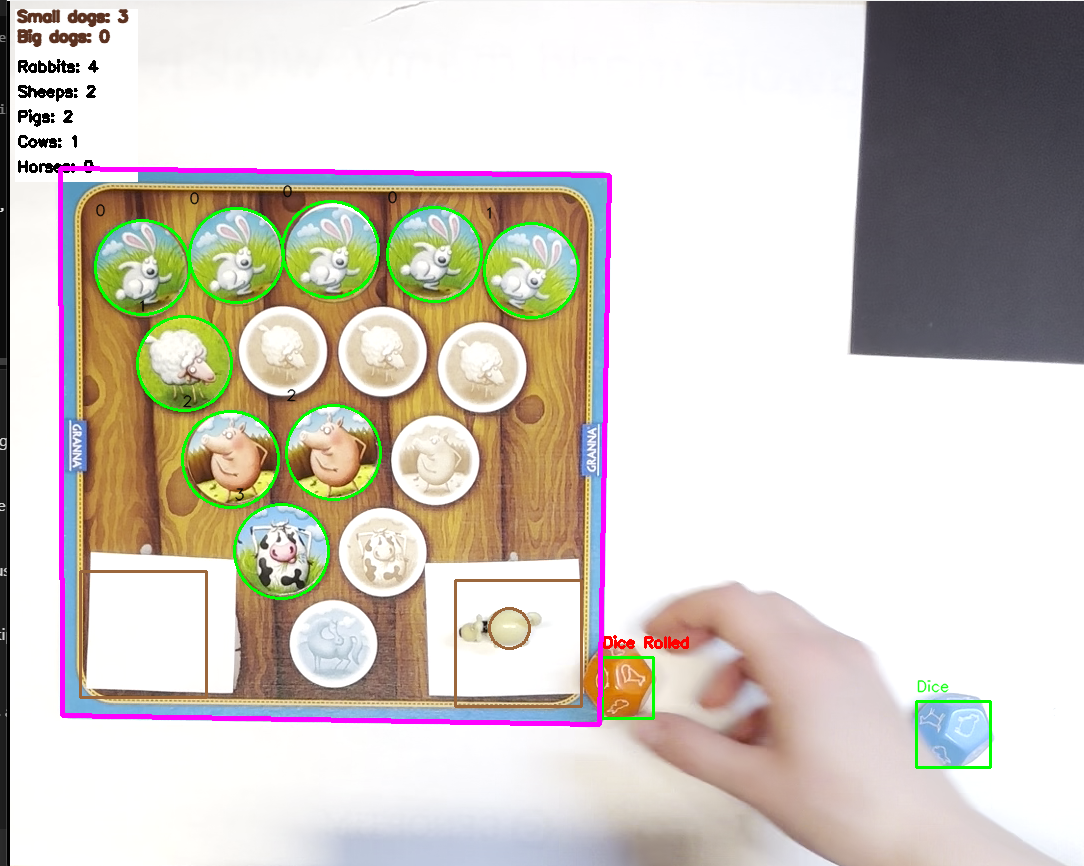

In [5]:
import cv2
import numpy as np
import time

def reorder_corners(corners):
    # Sort the points based on their x and y coordinates
    sorted_corners = sorted(corners, key=lambda x: x[0])  # Sort by x coordinate first
    top_left, top_right = sorted_corners[:2]
    bottom_left, bottom_right = sorted_corners[2:]

    # Further sort the top-left and top-right by their y-coordinate
    if top_left[1] > top_right[1]:
        top_left, top_right = top_right, top_left

    if bottom_left[1] > bottom_right[1]:
        bottom_left, bottom_right = bottom_right, bottom_left

    return np.array([top_left, top_right, bottom_left, bottom_right])
# Existing circle detection code
def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 1)
    edges = cv2.Canny(gray, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            approx = reorder_corners(approx.reshape(4, 2))
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(contour)
            if 0.8 <= aspect_ratio <= 1.2 and area > 50000:
                return approx, x, y, w, h
    return None, None, None, None, None

# New dice detection code
def create_tracker(tracker_type="CSRT"):
    if tracker_type == "CSRT":
        return cv2.TrackerCSRT_create()
    elif tracker_type == "KCF":
        return cv2.TrackerKCF_create()
    return None

def draw_bbox_with_area(frame, bbox, color=(255, 255, 255)):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)
    text_position = (p1[0], max(0, p1[1] - 10))
    cv2.putText(frame, "Dice", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

def is_square(bbox, tolerance=0.2):
    x, y, w, h = bbox
    aspect_ratio = w / h if w > h else h / w
    return 1 - tolerance <= aspect_ratio <= 1 + tolerance

def is_overlap(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper, threshold=0.3):
    x, y, w, h = bbox
    roi = frame[y:y+h, x:x+w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    orange_mask = cv2.inRange(hsv_roi, orange_lower, orange_upper)
    blue_mask = cv2.inRange(hsv_roi, blue_lower, blue_upper)
    orange_pixels = cv2.countNonZero(orange_mask)
    blue_pixels = cv2.countNonZero(blue_mask)
    total_pixels = w * h
    return (orange_pixels + blue_pixels) / total_pixels >= threshold


def compute_circle_size_and_tolerance():
    circle_size = 50  # Average circle radius in pixels
    tolerance = 0.07 * circle_size
    return circle_size, tolerance


def stabilize_circles(new_circles, previous_circles, alpha=1, distance_threshold=20):
    if previous_circles is None:
        return new_circles

    stabilized_circles = []
    for new_circle in new_circles:
        x_new, y_new, r_new = new_circle
        matched = False
        for prev_circle in previous_circles:
            x_prev, y_prev, r_prev = prev_circle
            distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)
            if distance < distance_threshold:
                x_stabilized = alpha * x_prev + (1 - alpha) * x_new
                y_stabilized = alpha * y_prev + (1 - alpha) * y_new
                r_stabilized = alpha * r_prev + (1 - alpha) * r_new
                stabilized_circles.append((x_stabilized, y_stabilized, r_stabilized))
                matched = True
                break
        if not matched:
            stabilized_circles.append(new_circle)

    return stabilized_circles

def extract_circle_region(frame, x, y, r):
    """
    Extracts the region of the frame inside a given circle.

    Parameters:
        frame (numpy.ndarray): The video frame.
        x (int): X-coordinate of the circle's center.
        y (int): Y-coordinate of the circle's center.
        r (int): Radius of the circle.

    Returns:
        numpy.ndarray: The cropped circular region.
    """
    # Create a mask with the same size as the frame
    mask = np.zeros_like(frame, dtype=np.uint8)

    # Draw a filled circle on the mask
    cv2.circle(mask, (x, y), r, (255, 255, 255), -1)

    # Apply the mask to the frame
    circular_region = cv2.bitwise_and(frame, mask)

    # Crop the bounding box around the circle
    x_min, y_min = max(0, x - r), max(0, y - r)
    x_max, y_max = min(frame.shape[1], x + r), min(frame.shape[0], y + r)
    cropped_region = circular_region[y_min:y_max, x_min:x_max]

    return cropped_region

def resize_region(region, template):
    """
    Resizes the detected region to the size of the template.
    
    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        template (numpy.ndarray): Template image to match against.

    Returns:
        numpy.ndarray: Resized detected region.
    """
    return cv2.resize(region, (template.shape[1], template.shape[0]))


def match_templates(region, templates):
    """
    Matches the detected region with each template using template matching.
    
    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        templates (list): List of template images.

    Returns:
        int: Index of the most similar template.
        float: Matching score of the best match.
    """
    best_match_idx = -1
    best_score = float('-inf')

    for i, template in enumerate(templates):
        # cv2.imshow("template", template)
        # Resize the region to match the template size
        resized_region = resize_region(region, template)
        
        # Perform template matching
        result = cv2.matchTemplate(resized_region, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        
        # Keep track of the best match
        if max_val > best_score:
            best_score = max_val
            best_match_idx = i

    return best_match_idx, best_score


def match_features(region, templates):
    """
    Matches the detected region with each template using feature matching.

    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        templates (list): List of template images.

    Returns:
        int: Index of the most similar template.
        float: Matching score of the best match.
    """
    orb = cv2.ORB_create()
    best_match_idx = -1
    best_score = 0

    # Convert the region to grayscale
    region_gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors for the region
    kp1, des1 = orb.detectAndCompute(region_gray, None)

    for i, template in enumerate(templates):
        # Convert the template to grayscale
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

        # Detect keypoints and descriptors for the template
        kp2, des2 = orb.detectAndCompute(template_gray, None)

        # Match features using BFMatcher
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)

        # Sort matches by distance
        matches = sorted(matches, key=lambda x: x.distance)

        # Calculate the score as the number of good matches
        score = len(matches)
        if score > best_score:
            best_score = score
            best_match_idx = i

    return best_match_idx, best_score




def detect_circles_and_dice_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    circle_size, tolerance = compute_circle_size_and_tolerance()
    previous_circles = None
    start_time = None
    finish_triggered = False
    no_circle_duration = 4
    circle_check_interval = 0.033

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    board_corners = board.reshape(4, 2)
    bottom_left = board_corners[1]
    bottom_right = board_corners[3]
    square_side = int(w * 0.23)
    roi_size = (square_side, square_side)

    orange_lower = np.array([4, 66, 114])
    orange_upper = np.array([15, 252, 253])
    blue_lower = np.array([90, 80, 100])
    blue_upper = np.array([120, 255, 255])


    trackers = []
    tracker_start_times = {}
    
    
    #for traiding:
    buffer = int(max(w,h)*0.15)
    extended_board_rect = (
        x - buffer,
        y - buffer,
        x + w + buffer,
        y + h + buffer
    )

    circle_outside_count = {}
    
    #for animal detection
    templates = [
            cv2.imread("./materials/rabbit.png"),
            cv2.imread("./materials/sheep.png"),
            cv2.imread("./materials/pig.png"),
            cv2.imread("./materials/cow.png"),
            cv2.imread("./materials/horse.png")
            ]
        
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)        
        
    #------------------------------------------- FINISH DETECTION by empty circles
        empty_circle_count = 0
        empty_circles_coordinates =[]
        
        empty_circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, 
            dp=1.2, minDist=50, 
            param1=200, param2=100, 
            minRadius=int(circle_size - tolerance*4),
            maxRadius=int(circle_size + tolerance*2))
        
        
        if empty_circles is not None:
            empty_circles = np.uint16(np.around(empty_circles))
            for circle in empty_circles[0, :]:
                x, y, r = circle
                empty_circles_coordinates.append((x,y))
                empty_circle_count +=1 
                # Create a circular mask for the detected circle
                mask = np.zeros_like(gray, dtype=np.uint8)
                cv2.circle(mask, (x, y), r, 255, -1)

                # Get dominant color inside the circle
                # dominant_color = get_dominant_color(frame, mask)
                # color_name = f"RGB({dominant_color[2]}, {dominant_color[1]}, {dominant_color[0]})"
                
                # Draw the circle and bounding box
                # cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
                # cv2.rectangle(frame, (x - r, y - r - 20), (x + r, y - r), (255, 255, 255), -1)

                # Put text (dominant color)
                # cv2.putText(frame, color_name, (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                # cv2.putText(frame, "EMPTY", (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        
        if empty_circle_count == 0:
            if start_time is None:
                start_time = time.time()
            elif time.time() - start_time > no_circle_duration:
                finish_triggered = True
        else:
            start_time = None
            finish_triggered = False
            
        if finish_triggered:
            cv2.putText(frame, "Game Won", (400,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    # ---------------------------------------
        #detecting the circles -> animal tokens (also the empty board animals)

        circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
            param1=70, param2=30,
            minRadius=int(circle_size - tolerance),
            maxRadius=int(circle_size + tolerance)
        )
        
        if circles is not None:
            circles = np.uint16(np.around(circles))[0, :]
            stabilized_circles = stabilize_circles(circles, previous_circles)
            previous_circles = stabilized_circles

            detected_animals=[0, 0, 0, 0, 0]
            
            for circle in stabilized_circles:
                x, y, r = map(int, circle)
                
                skip_circle = False
                for coord_x, coord_y in empty_circles_coordinates:
                    distance = np.sqrt((coord_x - x)**2 + (coord_y - y)**2)
                    if distance <= r+12:
                        skip_circle = True
                        break  # Skip further checks for this circle
                
                if skip_circle:
                    continue
                
            #Determining what animal it is----------------------------------
                animal = extract_circle_region(frame, x, y, r)
                # cv2.imshow("animal", animal)
                # cv2.imshow("templates", template[0])
                best_match_idx, best_score = match_templates(animal, templates)
                # best_match_idx, best_score = match_features(detected_region, templates)                
                detected_animals[best_match_idx] += 1
            #--------------------------------------------------------------

                # Draw the circle on the frame
                cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
                #todelete
                cv2.putText(frame, f"{best_match_idx}", (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                #
                
            #Determining trading --------------               
                #check if the circle is outside the board for trading
                if not (extended_board_rect[0] <= x <= extended_board_rect[2] and
                        extended_board_rect[1] <= y <= extended_board_rect[3]):
                    if (x, y) not in circle_outside_count:
                        circle_outside_count[(x, y)] = 1
                    else:
                        circle_outside_count[(x, y)] += 1

                    if circle_outside_count[(x, y)] > 5:
                        cv2.putText(frame, "Trading in place", (400, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                else:
                    if (x, y) in circle_outside_count:
                        del circle_outside_count[(x, y)]
            #-------------------------------
        
        #printing status of the game---------------
            cv2.rectangle(frame, (8, 8), (130, 180), (255, 255, 255), -1)
            cv2.putText(frame, f"Rabbits: {detected_animals[0]}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Sheeps: {detected_animals[1]}", (10, 95), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Pigs: {detected_animals[2]}", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Cows: {detected_animals[3]}", (10, 145), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Horses: {detected_animals[4]}", (10, 170), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        #-------------------------------------------


        cv2.polylines(frame, [board[[2,0,1,3]]], isClosed=True, color=(255, 0, 255), thickness=4)

        roi_bottom_right = (
            int(bottom_left[0] + (square_side//7)),
            int(bottom_left[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )
        roi_bottom_left = (
            int(bottom_right[0] - (square_side//7)- roi_size[0]),
            int(bottom_right[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )

#Not detecting inside board
        frame_with_border_masked = frame.copy()
        cv2.rectangle(frame_with_border_masked, board[0], 
                      board[3], (0, 0, 0), -1)
#detect dog as circles, determine dog boxes
        roi_frame_left = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
                               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
        roi_frame_right = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
                                roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]

        roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
        roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)

        circles_left = cv2.HoughCircles(roi_gray_left, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=10, maxRadius=50)

        circles_right = cv2.HoughCircles(roi_gray_right, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=30, minRadius=10, maxRadius=50)
        
#Show number of dogs
        dogs_stats1 = f"Small dogs: {circles_right.shape[1] if circles_right is not None else 0}"
        dogs_stats2 = f"Big dogs: {circles_left.shape[1] if circles_left is not None else 0}"
        cv2.putText(frame, dogs_stats1, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)
        cv2.putText(frame, dogs_stats2, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)

#visualise left dogs
        if circles_left is not None:
            circles_left = np.uint16(np.around(circles_left))
            for circle in circles_left[0, :]:
                cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)
#visualise right dogs
        if circles_right is not None:
            circles_right = np.uint16(np.around(circles_right))
            for circle in circles_right[0, :]:
                cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)

# Detect dice
        hsv_frame = cv2.cvtColor(frame_with_border_masked, cv2.COLOR_BGR2HSV)
        orange_mask = cv2.inRange(hsv_frame, orange_lower, orange_upper)
        blue_mask = cv2.inRange(hsv_frame, blue_lower, blue_upper)
        combined_mask = cv2.bitwise_or(orange_mask, blue_mask)
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detected_bboxes = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if 1000 < area < 4500:
                x, y, w, h = cv2.boundingRect(contour)
                if is_square((x, y, w, h)):
                    detected_bboxes.append((x, y, w, h, area))

        current_time = time.time()
        
        for bbox_data in detected_bboxes:
            bbox = bbox_data[:4]
            is_new = True
            for tracker, tracked_bbox in trackers:
                if is_overlap(bbox, tracked_bbox):
                    is_new = False
                    break

            if is_new and is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                tracker = create_tracker("KCF")
                tracker.init(frame, bbox)
                trackers.append((tracker, bbox))
                tracker_start_times[tracker] = current_time

        for i, (tracker, _) in enumerate(trackers):
            ok, bbox = tracker.update(frame)
            if ok:
                if is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                    trackers[i] = (tracker, bbox)
                    area = bbox[2] * bbox[3]
                    draw_bbox_with_area(frame, bbox, (0, 255, 0))
                    
#Dice rolled event trigger-------------------------------
                    if current_time - tracker_start_times[tracker] >= 1:
                        text_position = (bbox[0], bbox[1] - 10)
                        cv2.putText(frame, "Dice Rolled", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

#DETECTING FOR WOOLF-------------------------------------- NOTHING REALLY DONE.
                        # #check similarity
                        # x_wolf,y_wolf,w_wolf,h_wolf = bbox
                        # dice_to_detect = frame[y_wolf:y_wolf+h_wolf, x_wolf:x_wolf+w_wolf]
                        
                        # dice_to_detect = cv2.Canny(dice_to_detect, 50, 150)
                        # cv2.imshow("frame{i}", dice_to_detect)
                    
                else:
                    trackers[i] = None
            else:
                trackers[i] = None

        trackers = [t for t in trackers if t is not None]
        cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)
        cv2.polylines(frame, [board[[2, 0, 1, 3]]], isClosed=True, color=(255, 0, 255), thickness=4)
        cv2.imshow("Circles and Dice in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
# detect_circles_and_dice_in_video('./materials/E3.MP4')
# detect_circles_and_dice_in_video('./materials/E2.mp4')
# detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H3.MP4')

# ##Mary's
# detect_circles_and_dice_in_video('./materials/E1-T-W.MP4')
# detect_circles_and_dice_in_video('./materials/E2-T-L-W.MP4')
detect_circles_and_dice_in_video('./materials/E3-fastFinish.MP4')
# detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H3-shake-win.MP4')

C:\Users\mary9\AppData\Local\Temp\ipykernel_15108\970820310.py:92: RuntimeWarning: overflow encountered in scalar subtract
  distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)
C:\Users\mary9\AppData\Local\Temp\ipykernel_15108\970820310.py:92: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)


# All done, false positives.. cleaning up the code

In [43]:
import cv2
import numpy as np
import time
from collections import deque


def reorder_corners(corners):
    # Sort the points based on their x and y coordinates
    sorted_corners = sorted(corners, key=lambda x: x[0])  # Sort by x coordinate first
    top_left, top_right = sorted_corners[:2]
    bottom_left, bottom_right = sorted_corners[2:]

    # Further sort the top-left and top-right by their y-coordinate
    if top_left[1] > top_right[1]:
        top_left, top_right = top_right, top_left

    if bottom_left[1] > bottom_right[1]:
        bottom_left, bottom_right = bottom_right, bottom_left

    return np.array([top_left, top_right, bottom_left, bottom_right])

def detect_board(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 1)
    edges = cv2.Canny(gray, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            approx = reorder_corners(approx.reshape(4, 2))
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(contour)
            if 0.8 <= aspect_ratio <= 1.2 and area > 50000:
                return approx, x, y, w, h
    return None, None, None, None, None


def create_tracker(tracker_type="CSRT"):
    if tracker_type == "CSRT":
        return cv2.TrackerCSRT_create()
    elif tracker_type == "KCF":
        return cv2.TrackerKCF_create()
    elif tracker_type == "MIL":
        return cv2.TrackerMIL_create()
    elif tracker_type == "BOOSTING":
        return cv2.TrackerBoosting_create()
    return None

def draw_bbox_with_area(frame, bbox, text, color=(255, 255, 255)):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)
    text_position = (p1[0], max(0, p1[1] - 10))
    cv2.putText(frame, text, text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

def is_square(bbox, tolerance=0.2):
    x, y, w, h = bbox
    aspect_ratio = w / h if w > h else h / w
    return 1 - tolerance <= aspect_ratio <= 1 + tolerance

def is_overlap(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def is_overlap_with_tolerance(bbox1, bbox2, tolerance=1.2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    # Calculate the intersection coordinates
    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(x1 + w1, x2 + w2)
    inter_y2 = min(y1 + h1, y2 + h2)

    # Check if there is no intersection
    if inter_x1 >= inter_x2 or inter_y1 >= inter_y2:
        return False

    # Calculate intersection area
    inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)

    # Calculate the areas of both boxes
    area1 = w1 * h1
    area2 = w2 * h2

    # Calculate average area
    avg_area = (area1 + area2) / 2

    # Calculate the overlap ratio
    overlap_ratio = inter_area / avg_area

    # Return whether the overlap ratio is within the tolerance
    return overlap_ratio > tolerance


def is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper, threshold=0.3):
    x, y, w, h = bbox
    roi = frame[y:y+h, x:x+w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    orange_mask = cv2.inRange(hsv_roi, orange_lower, orange_upper)
    blue_mask = cv2.inRange(hsv_roi, blue_lower, blue_upper)
    orange_pixels = cv2.countNonZero(orange_mask)
    blue_pixels = cv2.countNonZero(blue_mask)
    total_pixels = w * h
    return (orange_pixels + blue_pixels) / total_pixels >= threshold


def compute_circle_size_and_tolerance():
    circle_size = 50  # Average circle radius in pixels
    tolerance = 0.07 * circle_size
    return circle_size, tolerance


def stabilize_circles(new_circles, previous_circles, alpha=1, distance_threshold=20):
    if previous_circles is None:
        return new_circles

    stabilized_circles = []
    for new_circle in new_circles:
        x_new, y_new, r_new = new_circle
        matched = False
        for prev_circle in previous_circles:
            x_prev, y_prev, r_prev = prev_circle
            distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)
            if distance < distance_threshold:
                x_stabilized = alpha * x_prev + (1 - alpha) * x_new
                y_stabilized = alpha * y_prev + (1 - alpha) * y_new
                r_stabilized = alpha * r_prev + (1 - alpha) * r_new
                stabilized_circles.append((x_stabilized, y_stabilized, r_stabilized))
                matched = True
                break
        if not matched:
            stabilized_circles.append(new_circle)

    return stabilized_circles

def extract_circle_region(frame, x, y, r):
    """
    Extracts the region of the frame inside a given circle.

    Parameters:
        frame (numpy.ndarray): The video frame.
        x (int): X-coordinate of the circle's center.
        y (int): Y-coordinate of the circle's center.
        r (int): Radius of the circle.

    Returns:
        numpy.ndarray: The cropped circular region.
    """
    # Create a mask with the same size as the frame
    mask = np.zeros_like(frame, dtype=np.uint8)

    # Draw a filled circle on the mask
    cv2.circle(mask, (x, y), r, (255, 255, 255), -1)

    # Apply the mask to the frame
    circular_region = cv2.bitwise_and(frame, mask)

    # Crop the bounding box around the circle
    x_min, y_min = max(0, x - r), max(0, y - r)
    x_max, y_max = min(frame.shape[1], x + r), min(frame.shape[0], y + r)
    cropped_region = circular_region[y_min:y_max, x_min:x_max]

    return cropped_region

def resize_region(region, template):
    """
    Resizes the detected region to the size of the template.
    
    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        template (numpy.ndarray): Template image to match against.

    Returns:
        numpy.ndarray: Resized detected region.
    """
    return cv2.resize(region, (template.shape[1], template.shape[0]))


def match_templates(region, templates):
    """
    Matches the detected region with each template using template matching.
    
    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        templates (list): List of template images.

    Returns:
        int: Index of the most similar template.
        float: Matching score of the best match.
    """
    best_match_idx = -1
    best_score = float('-inf')

    for i, template in enumerate(templates):
        # cv2.imshow("template", template)
        # Resize the region to match the template size
        resized_region = resize_region(region, template)
        
        # Perform template matching
        result = cv2.matchTemplate(resized_region, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        
        # Keep track of the best match
        if max_val > best_score:
            best_score = max_val
            best_match_idx = i

    return best_match_idx, best_score

def orb_match(fragment_gray, template_gray, match_threshold=15):
    """
    Matches features between a frame fragment and a template using ORB.

    Parameters:
        frame_fragment (numpy.ndarray): The image fragment to check.
        template (numpy.ndarray): The template to compare against.
        match_threshold (int): Minimum number of good matches to confirm a match.

    Returns:
        bool: True if the fragment matches the template, False otherwise.
    """
    orb = cv2.ORB_create()

    # Detect keypoints and compute descriptors
    kp1, des1 = orb.detectAndCompute(fragment_gray, None)
    kp2, des2 = orb.detectAndCompute(template_gray, None)

    # Check if descriptors are valid
    if des1 is None or des2 is None or len(des1) == 0 or len(des2) == 0:
        return False

    # Ensure descriptors have matching types
    if des1.dtype != des2.dtype:
        des2 = des2.astype(des1.dtype)

    # Use BFMatcher to find matches
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Filter matches by distance
    good_matches = [m for m in matches if m.distance < 30]  # Adjust threshold as needed

    # Check if the number of good matches exceeds the threshold
    return len(good_matches) >= match_threshold


def template_match(frame_fragment, template, threshold=0.6):
    """
    Determines if the template exists in the frame fragment using template matching.

    Parameters:
        frame_fragment (numpy.ndarray): The fragment of the video frame.
        template (numpy.ndarray): The template image to be matched.
        threshold (float): Minimum similarity threshold for a match.

    Returns:
        bool: True if the template matches the frame fragment, False otherwise.
    """
    # Perform template matching
    result = cv2.matchTemplate(frame_fragment, template, cv2.TM_SQDIFF_NORMED)
    
    #todelete
    # cv2.imshow("frame",frame_fragment)
    # cv2.imshow("wolf",template)
    # if cv2.waitKey(2000) & 0xFF == ord('q'):
    #     cv2.destroyWindow("frame")
    #     cv2.destroyWindow("wolf")
    #
    # Find the maximum similarity value
    _, max_val, _, _ = cv2.minMaxLoc(result)

    # Return True if the maximum value exceeds the threshold
    return max_val >= threshold


def match_features(region, templates):
    """
    Matches the detected region with each template using feature matching.

    Parameters:
        region (numpy.ndarray): Detected region (animal from video).
        templates (list): List of template images.

    Returns:
        int: Index of the most similar template.
        float: Matching score of the best match.
    """
    orb = cv2.ORB_create()
    best_match_idx = -1
    best_score = 0

    # Convert the region to grayscale
    region_gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors for the region
    kp1, des1 = orb.detectAndCompute(region_gray, None)

    for i, template in enumerate(templates):
        # Convert the template to grayscale
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

        # Detect keypoints and descriptors for the template
        kp2, des2 = orb.detectAndCompute(template_gray, None)

        # Match features using BFMatcher
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)

        # Sort matches by distance
        matches = sorted(matches, key=lambda x: x.distance)

        # Calculate the score as the number of good matches
        score = len(matches)
        if score > best_score:
            best_score = score
            best_match_idx = i

    return best_match_idx, best_score




def detect_circles_and_dice_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    circle_size, tolerance = compute_circle_size_and_tolerance()
    previous_circles = None
    start_time = None
    finish_triggered = False
    no_circle_duration = 4
    circle_check_interval = 0.033
    have_small_dog =0
    have_big_dog =0

    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    board, x, y, w, h = detect_board(frame)
    if board is None:
        print("Error: Could not detect the board.")
        cap.release()
        return

    board_corners = board.reshape(4, 2)
    bottom_left = board_corners[1]
    bottom_right = board_corners[3]
    square_side = int(w * 0.23)
    roi_size = (square_side, square_side)

    orange_lower = np.array([4, 66, 114])
    orange_upper = np.array([15, 252, 253])
    blue_lower = np.array([90, 80, 100])
    blue_upper = np.array([120, 255, 255])


    trackers = []
    tracker_start_times = {}
    
    
    #for traiding:
    buffer = int(max(w,h)*0.15)
    extended_board_rect = (
        x - buffer,
        y - buffer,
        x + w + buffer,
        y + h + buffer
    )

    circle_outside_count = {}
    
    #for animal detection
    templates = [
            cv2.imread("./materials/rabbit.png"),
            cv2.imread("./materials/sheep.png"),
            cv2.imread("./materials/pig.png"),
            cv2.imread("./materials/cow.png"),
            cv2.imread("./materials/horse.png")
            ]
    # wolf_template = cv2.imread("./materials/wolf_template.jpg", cv2.IMREAD_GRAYSCALE)
    # wolf_template = cv2.imread("./materials/wolf.png", cv2.IMREAD_GRAYSCALE)
    wolf_template = cv2.imread("./materials/wolf_upright.png", cv2.IMREAD_GRAYSCALE)
    
    #for tracking dog buying
    big_dog = deque(maxlen=40)
    small_dog = deque(maxlen=40)
    switch_dog = deque(maxlen=40)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)        
        
    #------------------------------------------- FINISH DETECTION by empty circles
        empty_circle_count = 0
        empty_circles_coordinates =[]
        animals_coordinates = []
        switch = 0
        
        empty_circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, 
            dp=1.2, minDist=50, 
            param1=200, param2=95, 
            minRadius=int(circle_size - tolerance*4),
            maxRadius=int(circle_size + tolerance*2))
        
        
        if empty_circles is not None:
            empty_circles = np.uint16(np.around(empty_circles))
            for circle in empty_circles[0, :]:
                x, y, r = circle
                empty_circles_coordinates.append((x,y))
                empty_circle_count +=1 
                # Create a circular mask for the detected circle
                mask = np.zeros_like(gray, dtype=np.uint8)
                cv2.circle(mask, (x, y), r, 255, -1)

                # Get dominant color inside the circle
                # dominant_color = get_dominant_color(frame, mask)
                # color_name = f"RGB({dominant_color[2]}, {dominant_color[1]}, {dominant_color[0]})"
                ## Draw the circle and bounding box
                # cv2.circle(frame, (x, y), r, (0,0,255), 2)
                ##checking whats the reason for false positives on empty spaces
                # Put text (dominant color)
                # cv2.putText(frame, color_name, (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                
                #debugging empty
                # cv2.rectangle(frame, (x - r, y - r - 20), (x + r, y - r), (0,0,255), -1)
                # cv2.putText(frame, "EMPTY", (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
        
        if empty_circle_count == 0:
            if start_time is None:
                start_time = time.time()
            elif time.time() - start_time > no_circle_duration:
                finish_triggered = True
        else:
            start_time = None
            finish_triggered = False
            
        if finish_triggered:
            cv2.putText(frame, "Game Won", (400,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    # ---------------------------------------
        #detecting the circles -> animal tokens (also the empty board animals)

        circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
            param1=70, param2=30,
            minRadius=int(circle_size - tolerance),
            maxRadius=int(circle_size + tolerance)
        )
        
        if circles is not None:
            circles = np.uint16(np.around(circles))[0, :]
            stabilized_circles = stabilize_circles(circles, previous_circles)
            previous_circles = stabilized_circles

            detected_animals=[0, 0, 0, 0, 0]
            
            for circle in stabilized_circles:
                x, y, r = map(int, circle)
                
                skip_circle = False
                for coord_x, coord_y in empty_circles_coordinates:
                    distance = np.sqrt((coord_x - x)**2 + (coord_y - y)**2)
                    if distance <= r+12:
                        skip_circle = True
                        break  # Skip further checks for this circle
                
                if skip_circle:
                    continue
                
            #Determining what animal it is----------------------------------
                animal = extract_circle_region(frame, x, y, r)
                # cv2.imshow("animal", animal)
                # cv2.imshow("templates", template[0])
                best_match_idx, best_score = match_templates(animal, templates)
                # best_match_idx, best_score = match_features(animal, templates)                
                detected_animals[best_match_idx] += 1
            #--------------------------------------------------------------

                # Draw the circle on the frame
                cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
                animals_coordinates.append((x,y))
                #todelete
                # cv2.putText(frame, f"{best_match_idx}", (x - r, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                #
                
            #Determining trading --------------               
                #check if the circle is outside the board for trading
                if not (extended_board_rect[0] <= x <= extended_board_rect[2] and
                        extended_board_rect[1] <= y <= extended_board_rect[3]):
                    if (x, y) not in circle_outside_count:
                        circle_outside_count[(x, y)] = 1
                    else:
                        circle_outside_count[(x, y)] += 1

                    if circle_outside_count[(x, y)] > 5:
                        # cv2.rectangle()
                        cv2.putText(frame, "Trading in place", (400, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                else:
                    if (x, y) in circle_outside_count:
                        del circle_outside_count[(x, y)]
            #-------------------------------
        
        #printing status of the game---------------
            cv2.rectangle(frame, (8, 8), (130, 180), (255, 255, 255), -1)
            cv2.putText(frame, f"Rabbits: {detected_animals[0]}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Sheeps: {detected_animals[1]}", (10, 95), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Pigs: {detected_animals[2]}", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Cows: {detected_animals[3]}", (10, 145), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            cv2.putText(frame, f"Horses: {detected_animals[4]}", (10, 170), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        #-------------------------------------------


        cv2.polylines(frame, [board[[2,0,1,3]]], isClosed=True, color=(255, 0, 255), thickness=4)

        roi_bottom_right = (
            int(bottom_left[0] + (square_side//4)),
            int(bottom_left[1] - (square_side//4) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )
        roi_bottom_left = (
            int(bottom_right[0] - (square_side//7)- roi_size[0]),
            int(bottom_right[1] - (square_side//7) - roi_size[1]),
            roi_size[0],
            roi_size[1]
        )

#Not detecting inside board
        frame_with_border_masked = frame.copy()
        cv2.rectangle(frame_with_border_masked, board[0], 
                      board[3], (0, 0, 0), -1)
#detect dog as circles, determine dog boxes
        roi_frame_right = frame[roi_bottom_right[1]:roi_bottom_right[1] + roi_bottom_right[3], 
                               roi_bottom_right[0]:roi_bottom_right[0] + roi_bottom_right[2]]
        roi_frame_left = frame[roi_bottom_left[1]:roi_bottom_left[1] + roi_bottom_left[3], 
                                roi_bottom_left[0]:roi_bottom_left[0] + roi_bottom_left[2]]

        roi_gray_left = cv2.cvtColor(roi_frame_left, cv2.COLOR_BGR2GRAY)
        roi_gray_right = cv2.cvtColor(roi_frame_right, cv2.COLOR_BGR2GRAY)
        l=cv2.GaussianBlur(roi_gray_left, (5, 5), 1.4)
        r=cv2.GaussianBlur(roi_gray_right, (5, 5), 1.4)
        
        minradius = int(circle_size//4)
        circles_left = cv2.HoughCircles(l, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=20, minRadius=minradius, maxRadius=50)

        circles_right = cv2.HoughCircles(r, cv2.HOUGH_GRADIENT, 1, roi_size[0] / 4,
                                         param1=50, param2=20, minRadius=minradius, maxRadius=50)
        
        if circles_left is not None:
            small_dog.append(True)
        else:
             small_dog.append(False)
                  
        if circles_right is not None:
            big_dog.append(True)
        else:
            big_dog.append(False)
            
        small_count = sum(small_dog)
        big_count = sum(big_dog)
        if small_count > (len(small_dog) - small_count) //2 : 
            switch = 1 if have_small_dog == False else 0
            have_small_dog = True
        else:
            have_small_dog = False
            
        if big_count > (len(big_dog) - big_count)//2 : 
            switch = 1 if have_big_dog == False else 0
            have_big_dog = True
        else:
            have_big_dog = False
            
        switch_dog.append(switch)

        #Show having dogs
        cv2.putText(frame, f"Small dog: {have_small_dog}", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)
        cv2.putText(frame, f"Big dog: {have_big_dog}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (32, 50, 92), 2, cv2.LINE_AA)
        if sum(switch_dog) >0:
            cv2.putText(frame, "Got a dog", (200, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# # #visualise left dogs
#         if circles_left is not None:
#             circles_left = np.uint16(np.around(circles_left))
#             for circle in circles_left[0, :]:
#                 cv2.circle(roi_frame_left, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)
# #visualise right dogs
#         if circles_right is not None:
#             circles_right = np.uint16(np.around(circles_right))
#             for circle in circles_right[0, :]:
#                 cv2.circle(roi_frame_right, (circle[0], circle[1]), circle[2], (60, 103, 155), 2)
#         cv2.rectangle(frame, roi_bottom_right[:2], (roi_bottom_right[0] + roi_size[0], roi_bottom_right[1] + roi_size[1]), (60, 103, 155), 2)
#         cv2.rectangle(frame, roi_bottom_left[:2], (roi_bottom_left[0] + roi_size[0], roi_bottom_left[1] + roi_size[1]), (60, 103, 155), 2)
        
# Detect dice
        hsv_frame = cv2.cvtColor(frame_with_border_masked, cv2.COLOR_BGR2HSV)
        orange_mask = cv2.inRange(hsv_frame, orange_lower, orange_upper)
        blue_mask = cv2.inRange(hsv_frame, blue_lower, blue_upper)
        combined_mask = cv2.bitwise_or(orange_mask, blue_mask)
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detected_bboxes = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if 1000 < area < 4500:
                x, y, w, h = cv2.boundingRect(contour)
                
                #for the case when pigs are dices in trading
                skip_dice = False
                for coord_x, coord_y in animals_coordinates:
                    distance = np.sqrt((coord_x - x)**2 + (coord_y - y)**2)
                    if distance <= w:
                        skip_dice = True
                        break  # Skip further checks for this circle
                
                if skip_dice:
                    continue
                
                if is_square((x, y, w, h)):
                    detected_bboxes.append((x, y, w, h, area))

        current_time = time.time()
        
        for bbox_data in detected_bboxes:
            bbox = bbox_data[:4]
            is_new = True
            for tracker, tracked_bbox in trackers:
                if is_overlap(bbox, tracked_bbox):
                    is_new = False
                    break

            if is_new and is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                tracker = create_tracker("KCF")
                tracker.init(frame, bbox)
                trackers.append((tracker, bbox))
                tracker_start_times[tracker] = current_time

        for i, (tracker, _) in enumerate(trackers):
            ok, bbox = tracker.update(frame)
            if ok:
                if is_valid_color(frame, bbox, orange_lower, orange_upper, blue_lower, blue_upper):
                    trackers[i] = (tracker, bbox)
                    area = bbox[2] * bbox[3]
                    draw_bbox_with_area(frame, bbox, "Dice", (0, 255, 0))
                    
#Dice rolled event trigger-------------------------------
                    if current_time - tracker_start_times[tracker] >= 2:
                        text_position = (bbox[0], bbox[1] - 10)
                        cv2.putText(frame, "Dice Rolled", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

#DETECTING FOR WOOLF-------------------------------------- 
                        #check similarity
                        x_wolf,y_wolf,w_wolf,h_wolf = bbox
                        dice_to_detect = frame[y_wolf:y_wolf+h_wolf, x_wolf:x_wolf+w_wolf]
                        dice_to_detect = cv2.cvtColor(dice_to_detect, cv2.COLOR_BGR2GRAY)

                        # cv2.imshow("frame{i}", dice_to_detect)
                        # print(dice_to_detect.shape, wolf_template.shape)
                        template_height, template_width = wolf_template.shape[:2]
                        dice_resized = cv2.resize(dice_to_detect, (template_width, template_height), interpolation=cv2.INTER_AREA)
                        
                        #todelete
                        # cv2.imshow("frame",dice_resized)
                        # cv2.imshow("wolf",wolf_template)
                        # if cv2.waitKey(10) & 0xFF == ord('w'):
                        #     cv2.destroyWindow("frame")
                        #     cv2.destroyWindow("wolf")
                            
                        orb = orb_match(dice_resized, wolf_template)
                        tempmatch = template_match(dice_resized, wolf_template)
                        
                        if orb is True:
                            cv2.putText(frame, "Woolf detected by orb", (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 1 , (0, 0, 255), 2)
                        if tempmatch is True:
                            cv2.putText(frame, "Woolf detected", (400, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                else:
                    trackers[i] = None
            else:
                trackers[i] = None

        trackers = [t for t in trackers if t is not None]
        cv2.imshow("Circles and Dice in Video", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
# detect_circles_and_dice_in_video('./materials/E3.MP4')
# detect_circles_and_dice_in_video('./materials/E2.mp4')
# detect_circles_and_dice_in_video('./materials/H1-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H2-angle-F.MP4')
# detect_circles_and_dice_in_video('./materials/H3.MP4')

# detect_circles_and_dice_in_video('./materials/E1-short.MP4')

# ## Final movies (download at semestr5)
# detect_circles_and_dice_in_video('./materials/E1.MP4')
# detect_circles_and_dice_in_video('./materials/E2.MP4')
# detect_circles_and_dice_in_video('./materials/E3.MP4')

# detect_circles_and_dice_in_video('./materials/M1.MP4')
# detect_circles_and_dice_in_video('./materials/M2.MP4')
# detect_circles_and_dice_in_video('./materials/M3.MP4')

detect_circles_and_dice_in_video('./materials/H1.MP4')
detect_circles_and_dice_in_video('./materials/H2.MP4')
detect_circles_and_dice_in_video('./materials/H3.MP4')


Error: Could not detect the board.


C:\Users\mary9\AppData\Local\Temp\ipykernel_15108\2269242252.py:129: RuntimeWarning: overflow encountered in scalar subtract
  distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)
C:\Users\mary9\AppData\Local\Temp\ipykernel_15108\2269242252.py:129: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((x_new - x_prev)**2 + (y_new - y_prev)**2)
